## 1. 导入库

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# LightGBM
import lightgbm as lgb

# 评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# 设置绘图样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (15, 6)

print("✅ 库导入完成")

✅ 库导入完成


## 2. 加载数据

In [7]:
# 加载数据
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# 转换时间戳
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])

# 按时间排序（非常重要！）
train_df = train_df.sort_values('Timestamp').reset_index(drop=True)
test_df = test_df.sort_values('Timestamp').reset_index(drop=True)

print(f"训练数据形状: {train_df.shape}")
print(f"测试数据形状: {test_df.shape}")
print(f"\n数据范围:")
print(f"训练集: {train_df['Timestamp'].min()} 到 {train_df['Timestamp'].max()}")
print(f"测试集: {test_df['Timestamp'].min()} 到 {test_df['Timestamp'].max()}")

train_df.head()

训练数据形状: (484202, 7)
测试数据形状: (2881, 6)

数据范围:
训练集: 2012-01-01 10:00:00 到 2025-10-23 23:15:00
测试集: 2025-10-23 23:30:00 到 2025-11-22 23:30:00


,Timestamp,Open,High,Low,Close,Volume,Target
0,2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.0,0.0
1,2012-01-01 10:15:00,4.58,4.58,4.58,4.58,0.0,0.0
2,2012-01-01 10:30:00,4.58,4.58,4.58,4.58,0.0,0.0
3,2012-01-01 10:45:00,4.58,4.58,4.58,4.58,0.0,0.0
4,2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.0,0.0


In [8]:
# 检查数据基本信息
print("训练数据列:")
print(train_df.columns.tolist())
print("\n测试数据列:")
print(test_df.columns.tolist())
print("\n训练数据信息:")
train_df.info()

训练数据列:
['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target']

测试数据列:
['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']

训练数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484202 entries, 0 to 484201
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Timestamp  484202 non-null  datetime64[ns]
 1   Open       484202 non-null  float64       
 2   High       484202 non-null  float64       
 3   Low        484202 non-null  float64       
 4   Close      484202 non-null  float64       
 5   Volume     484202 non-null  float64       
 6   Target     484202 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 25.9 MB


## 3. 特征工程

创建时间序列特征，遵循严格的时序原则：
- **滞后特征**: 使用过去的值
- **滚动窗口特征**: 滚动均值、标准差等
- **时间特征**: 小时、星期几等
- **价格变化特征**: 收益率、价格差等

In [9]:
def create_time_features(df):
    """创建时间特征"""
    df = df.copy()
    
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['day_of_month'] = df['Timestamp'].dt.day
    df['month'] = df['Timestamp'].dt.month
    df['quarter'] = df['Timestamp'].dt.quarter
    df['year'] = df['Timestamp'].dt.year
    df['day_of_year'] = df['Timestamp'].dt.dayofyear
    df['week_of_year'] = df['Timestamp'].dt.isocalendar().week
    
    # 周期性编码（对于小时）
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # 周期性编码（对于星期）
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # 周期性编码（对于月份）
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

print("✅ 时间特征函数定义完成")

✅ 时间特征函数定义完成


In [10]:
def create_lag_features(df, target_col='Target', lags=[1, 2, 3, 4, 6, 12, 24, 48, 96]):
    """创建滞后特征
    
    对于15分钟间隔的数据:
    - lag 1 = 15分钟前
    - lag 4 = 1小时前
    - lag 96 = 1天前 (24小时 * 4个15分钟)
    - lag 672 = 1周前 (7天 * 96)
    """
    df = df.copy()
    
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    return df

print("✅ 滞后特征函数定义完成")

✅ 滞后特征函数定义完成


In [11]:
def create_rolling_features(df, target_col='Target', windows=[4, 12, 24, 96]):
    """创建滚动窗口特征
    
    windows:
    - 4 = 1小时
    - 12 = 3小时
    - 24 = 6小时
    - 96 = 1天
    """
    df = df.copy()
    
    for window in windows:
        # 滚动均值
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        
        # 滚动标准差
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
        
        # 滚动最大值
        df[f'{target_col}_rolling_max_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).max()
        
        # 滚动最小值
        df[f'{target_col}_rolling_min_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).min()
        
        # 滚动范围
        df[f'{target_col}_rolling_range_{window}'] = (df[f'{target_col}_rolling_max_{window}'] - 
                                                       df[f'{target_col}_rolling_min_{window}'])
    
    return df

print("✅ 滚动特征函数定义完成")

✅ 滚动特征函数定义完成


In [12]:
def create_price_features(df):
    """创建价格相关特征"""
    df = df.copy()
    
    # OHLC特征（如果存在）
    if all(col in df.columns for col in ['Open', 'High', 'Low', 'Close']):
        # 价格范围
        df['price_range'] = df['High'] - df['Low']
        
        # 价格变化
        df['price_change'] = df['Close'] - df['Open']
        
        # 价格变化率
        df['price_change_pct'] = (df['Close'] - df['Open']) / (df['Open'] + 1e-8)
        
        # 上影线和下影线
        df['upper_shadow'] = df['High'] - df[['Open', 'Close']].max(axis=1)
        df['lower_shadow'] = df[['Open', 'Close']].min(axis=1) - df['Low']
        
        # 实体大小
        df['body_size'] = abs(df['Close'] - df['Open'])
    
    # 成交量特征（如果存在）
    if 'Volume' in df.columns:
        df['volume_log'] = np.log1p(df['Volume'])
        df['volume_ma_4'] = df['Volume'].shift(1).rolling(window=4, min_periods=1).mean()
        df['volume_ma_24'] = df['Volume'].shift(1).rolling(window=24, min_periods=1).mean()
    
    return df

print("✅ 价格特征函数定义完成")

✅ 价格特征函数定义完成


In [13]:
def create_target_change_features(df, target_col='Target'):
    """创建目标变量的变化特征"""
    df = df.copy()
    
    # 目标的变化
    df[f'{target_col}_diff_1'] = df[target_col].diff(1)
    df[f'{target_col}_diff_4'] = df[target_col].diff(4)
    df[f'{target_col}_diff_96'] = df[target_col].diff(96)
    
    # 目标的收益率
    df[f'{target_col}_return_1'] = df[target_col].pct_change(1)
    df[f'{target_col}_return_4'] = df[target_col].pct_change(4)
    df[f'{target_col}_return_96'] = df[target_col].pct_change(96)
    
    return df

print("✅ 目标变化特征函数定义完成")

✅ 目标变化特征函数定义完成


In [14]:
def create_all_features(df, target_col='Target', is_train=True):
    """创建所有特征"""
    print(f"原始数据形状: {df.shape}")
    
    # 1. 时间特征
    df = create_time_features(df)
    print(f"添加时间特征后: {df.shape}")
    
    # 2. 价格特征
    df = create_price_features(df)
    print(f"添加价格特征后: {df.shape}")
    
    if is_train and target_col in df.columns:
        # 3. 目标变化特征（仅训练集）
        df = create_target_change_features(df, target_col)
        print(f"添加目标变化特征后: {df.shape}")
        
        # 4. 滞后特征
        df = create_lag_features(df, target_col)
        print(f"添加滞后特征后: {df.shape}")
        
        # 5. 滚动特征
        df = create_rolling_features(df, target_col)
        print(f"添加滚动特征后: {df.shape}")
    else:
        # 对于测试集，使用Close作为代理创建特征
        if 'Close' in df.columns:
            df = create_target_change_features(df, 'Close')
            df = create_lag_features(df, 'Close')
            df = create_rolling_features(df, 'Close')
            
            # 重命名特征以匹配训练集
            rename_dict = {col: col.replace('Close_', 'Target_') 
                          for col in df.columns if col.startswith('Close_')}
            df = df.rename(columns=rename_dict)
            print(f"测试集特征创建后: {df.shape}")
    
    return df

print("✅ 主特征创建函数定义完成")

✅ 主特征创建函数定义完成


In [15]:
# 创建训练集特征
print("创建训练集特征...")
train_featured = create_all_features(train_df.copy(), target_col='Target', is_train=True)

print(f"\n最终训练集特征数: {train_featured.shape[1]}")
print(f"新增特征数: {train_featured.shape[1] - train_df.shape[1]}")

创建训练集特征...
原始数据形状: (484202, 7)
添加时间特征后: (484202, 21)
添加时间特征后: (484202, 21)
添加价格特征后: (484202, 30)
添加目标变化特征后: (484202, 36)
添加价格特征后: (484202, 30)
添加目标变化特征后: (484202, 36)
添加滞后特征后: (484202, 45)
添加滞后特征后: (484202, 45)
添加滚动特征后: (484202, 65)

最终训练集特征数: 65
新增特征数: 58
添加滚动特征后: (484202, 65)

最终训练集特征数: 65
新增特征数: 58


In [16]:
# 查看特征列表
feature_cols = [col for col in train_featured.columns 
                if col not in ['Timestamp', 'Target']]

print(f"\n特征列表 ({len(feature_cols)} 个):")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:3d}. {col}")


特征列表 (63 个):
  1. Open
  2. High
  3. Low
  4. Close
  5. Volume
  6. hour
  7. day_of_week
  8. day_of_month
  9. month
 10. quarter
 11. year
 12. day_of_year
 13. week_of_year
 14. hour_sin
 15. hour_cos
 16. day_sin
 17. day_cos
 18. month_sin
 19. month_cos
 20. price_range
 21. price_change
 22. price_change_pct
 23. upper_shadow
 24. lower_shadow
 25. body_size
 26. volume_log
 27. volume_ma_4
 28. volume_ma_24
 29. Target_diff_1
 30. Target_diff_4
 31. Target_diff_96
 32. Target_return_1
 33. Target_return_4
 34. Target_return_96
 35. Target_lag_1
 36. Target_lag_2
 37. Target_lag_3
 38. Target_lag_4
 39. Target_lag_6
 40. Target_lag_12
 41. Target_lag_24
 42. Target_lag_48
 43. Target_lag_96
 44. Target_rolling_mean_4
 45. Target_rolling_std_4
 46. Target_rolling_max_4
 47. Target_rolling_min_4
 48. Target_rolling_range_4
 49. Target_rolling_mean_12
 50. Target_rolling_std_12
 51. Target_rolling_max_12
 52. Target_rolling_min_12
 53. Target_rolling_range_12
 54. Target_rollin

## 4. 数据清洗和准备

In [17]:
# 删除包含NaN的行（由于滞后特征）
print(f"清洗前数据形状: {train_featured.shape}")
print(f"NaN值数量: {train_featured.isna().sum().sum()}")

# 保存Timestamp列
timestamps = train_featured['Timestamp'].copy()

# 删除包含无穷大的值
train_featured = train_featured.replace([np.inf, -np.inf], np.nan)

# 删除NaN行
valid_idx = train_featured[feature_cols + ['Target']].notna().all(axis=1)
train_featured = train_featured[valid_idx].reset_index(drop=True)
timestamps = timestamps[valid_idx].reset_index(drop=True)

print(f"清洗后数据形状: {train_featured.shape}")
print(f"保留的数据比例: {train_featured.shape[0] / len(valid_idx) * 100:.2f}%")

清洗前数据形状: (484202, 65)
NaN值数量: 72775
清洗后数据形状: (423389, 65)
保留的数据比例: 87.44%
清洗后数据形状: (423389, 65)
保留的数据比例: 87.44%


In [18]:
# 准备特征和目标
X = train_featured[feature_cols].values
y = train_featured['Target'].values

print(f"特征矩阵形状: {X.shape}")
print(f"目标向量形状: {y.shape}")
print(f"\n目标统计:")
print(f"  均值: {y.mean():.6f}")
print(f"  标准差: {y.std():.6f}")
print(f"  最小值: {y.min():.6f}")
print(f"  最大值: {y.max():.6f}")

特征矩阵形状: (423389, 63)
目标向量形状: (423389,)

目标统计:
  均值: 0.000019
  标准差: 0.005181
  最小值: -0.276799
  最大值: 0.598299


## 5. 时间序列交叉验证

使用时间序列分割，确保验证集总是在训练集之后。

In [19]:
# 使用最后20%作为验证集
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:]
y_val = y[train_size:]

print(f"训练集大小: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"验证集大小: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"\n训练集时间范围: {timestamps.iloc[0]} 到 {timestamps.iloc[train_size-1]}")
print(f"验证集时间范围: {timestamps.iloc[train_size]} 到 {timestamps.iloc[-1]}")

训练集大小: 338711 (80.0%)
验证集大小: 84678 (20.0%)

训练集时间范围: 2012-01-11 20:00:00 到 2023-05-08 10:45:00
验证集时间范围: 2023-05-08 11:00:00 到 2025-10-23 23:15:00


## 6. LightGBM模型训练

In [20]:
# LightGBM参数
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1
}

print("LightGBM参数:")
for key, value in params.items():
    print(f"  {key}: {value}")

LightGBM参数:
  objective: regression
  metric: rmse
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.05
  feature_fraction: 0.8
  bagging_fraction: 0.8
  bagging_freq: 5
  max_depth: -1
  min_child_samples: 20
  reg_alpha: 0.1
  reg_lambda: 0.1
  verbose: -1
  random_state: 42
  n_jobs: -1


In [21]:
# 创建LightGBM数据集
train_data = lgb.Dataset(X_train, label=y_train, feature_name=feature_cols)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, feature_name=feature_cols)

print("✅ LightGBM数据集创建完成")

✅ LightGBM数据集创建完成


In [22]:
# 训练模型
print("开始训练LightGBM模型...\n")

evals_result = {}
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
        lgb.record_evaluation(evals_result)
    ]
)

print(f"\n✅ 训练完成!")
print(f"最佳迭代次数: {model.best_iteration}")
print(f"最佳验证RMSE: {evals_result['valid']['rmse'][model.best_iteration-1]:.6f}")

开始训练LightGBM模型...

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.00133086	valid's rmse: 0.000218755
[100]	train's rmse: 0.00133086	valid's rmse: 0.000218755
[200]	train's rmse: 0.00106035	valid's rmse: 0.000191378
[200]	train's rmse: 0.00106035	valid's rmse: 0.000191378
[300]	train's rmse: 0.000928701	valid's rmse: 0.000184293
[300]	train's rmse: 0.000928701	valid's rmse: 0.000184293
[400]	train's rmse: 0.000838357	valid's rmse: 0.000177454
[400]	train's rmse: 0.000838357	valid's rmse: 0.000177454
[500]	train's rmse: 0.00077297	valid's rmse: 0.000172918
[500]	train's rmse: 0.00077297	valid's rmse: 0.000172918
[600]	train's rmse: 0.000722148	valid's rmse: 0.000164202
[600]	train's rmse: 0.000722148	valid's rmse: 0.000164202
[700]	train's rmse: 0.000679763	valid's rmse: 0.000157676
[700]	train's rmse: 0.000679763	valid's rmse: 0.000157676
[800]	train's rmse: 0.000640036	valid's rmse: 0.00015

## 7. 模型评估

In [23]:
# 在验证集上预测
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)

# 计算评估指标
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("="*60)
print("验证集评估结果:")
print("="*60)
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE:  {mae:.6f}")
print(f"  R²:   {r2:.6f}")
print("="*60)

验证集评估结果:
  RMSE: 0.000149
  MAE:  0.000092
  R²:   0.996377


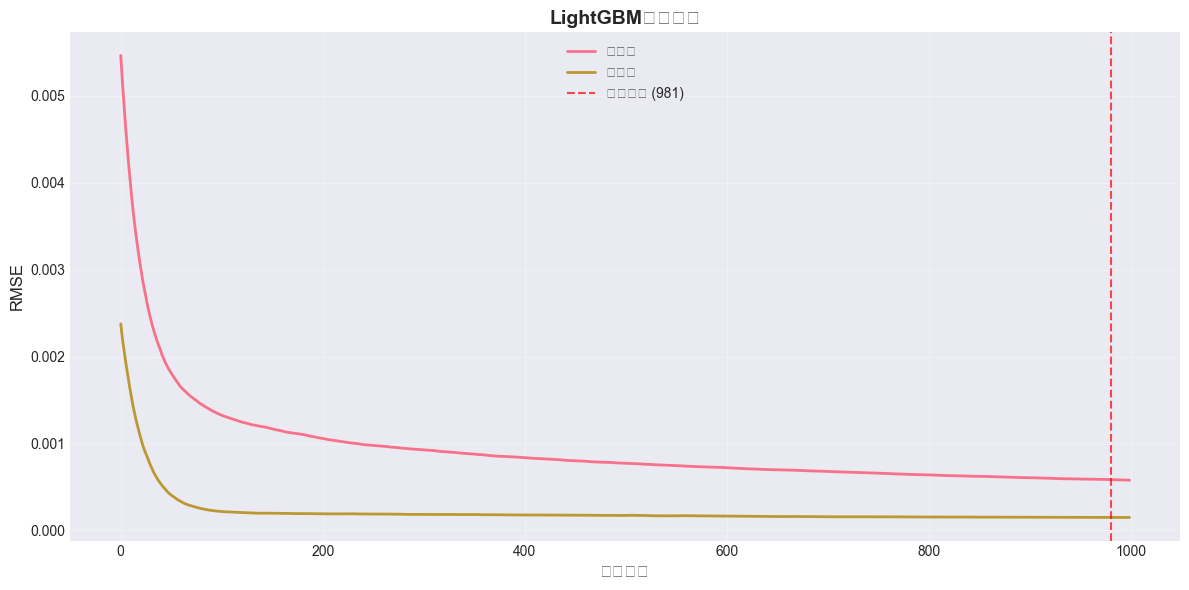

In [24]:
# 训练曲线
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(evals_result['train']['rmse'], label='训练集', linewidth=2)
ax.plot(evals_result['valid']['rmse'], label='验证集', linewidth=2)
ax.axvline(x=model.best_iteration, color='r', linestyle='--', 
           label=f'最佳迭代 ({model.best_iteration})', alpha=0.7)

ax.set_xlabel('迭代次数', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('LightGBM训练曲线', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 特征重要性分析

In [25]:
# 获取特征重要性
importance = model.feature_importance(importance_type='gain')
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

print("Top 20 重要特征:")
print(feature_importance_df.head(20).to_string(index=False))

Top 20 重要特征:
                feature  importance
          Target_diff_1   21.359850
         Target_diff_96   20.143712
          Target_diff_4   15.093088
           Target_lag_1    5.274061
        Target_return_1    5.089660
          Target_lag_96    3.827090
       Target_return_96    3.115204
           Target_lag_4    2.902597
        Target_return_4    2.638516
       price_change_pct    1.029695
  Target_rolling_min_24    0.716898
  Target_rolling_min_96    0.437421
  Target_rolling_min_12    0.430413
  Target_rolling_max_12    0.393946
           Target_lag_2    0.335935
 Target_rolling_mean_96    0.230589
   Target_rolling_min_4    0.223252
 Target_rolling_mean_12    0.220362
   Target_rolling_max_4    0.191792
Target_rolling_range_96    0.174515


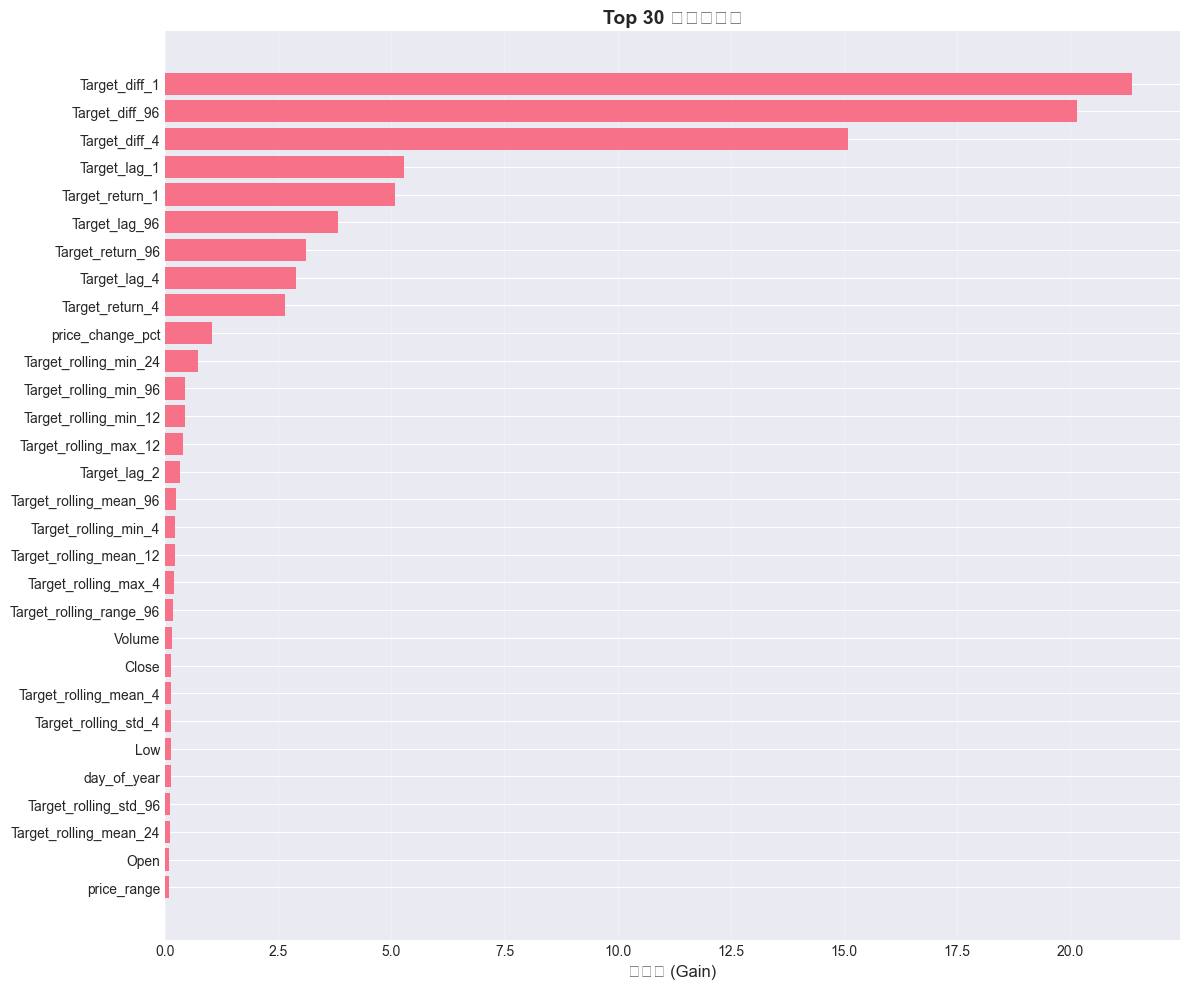

In [26]:
# 可视化特征重要性
top_n = 30
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(12, 10))
plt.barh(range(top_n), top_features['importance'].values)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('重要性 (Gain)', fontsize=12)
plt.title(f'Top {top_n} 特征重要性', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 9. 预测可视化

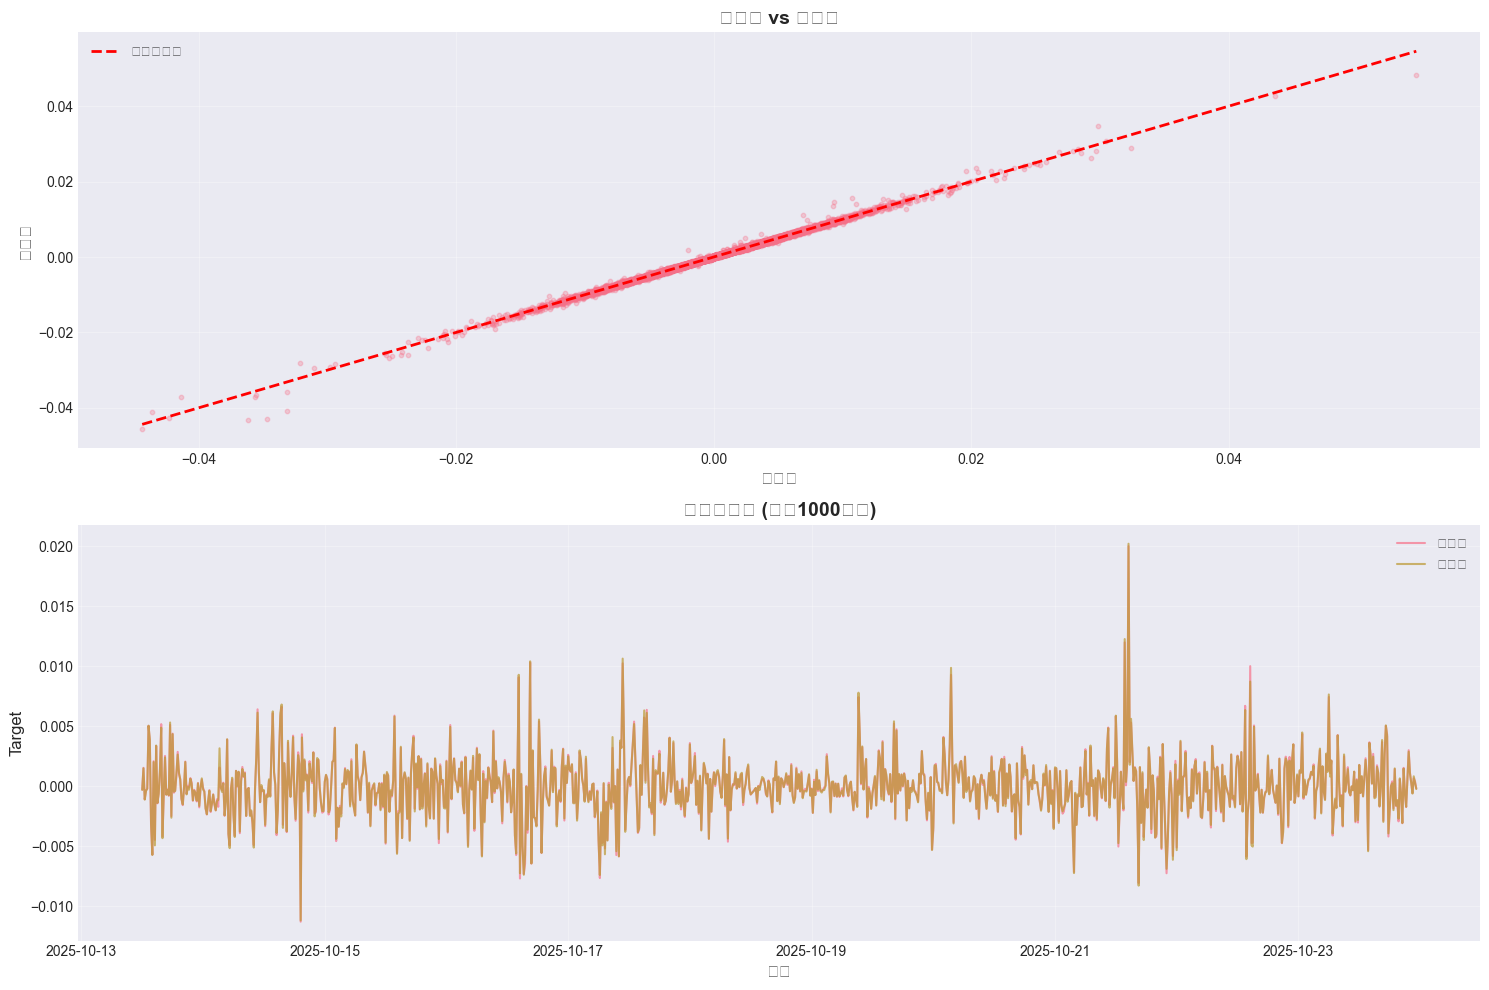

In [27]:
# 实际值 vs 预测值
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 散点图
axes[0].scatter(y_val, y_val_pred, alpha=0.3, s=10)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
             'r--', lw=2, label='完美预测线')
axes[0].set_xlabel('实际值', fontsize=12)
axes[0].set_ylabel('预测值', fontsize=12)
axes[0].set_title('实际值 vs 预测值', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 时间序列图（显示最后1000个点）
display_size = min(1000, len(y_val))
val_timestamps = timestamps.iloc[train_size:].reset_index(drop=True)

axes[1].plot(val_timestamps.iloc[-display_size:], 
             y_val[-display_size:], 
             label='实际值', linewidth=1.5, alpha=0.7)
axes[1].plot(val_timestamps.iloc[-display_size:], 
             y_val_pred[-display_size:], 
             label='预测值', linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('时间', fontsize=12)
axes[1].set_ylabel('Target', fontsize=12)
axes[1].set_title(f'验证集预测 (最后{display_size}个点)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

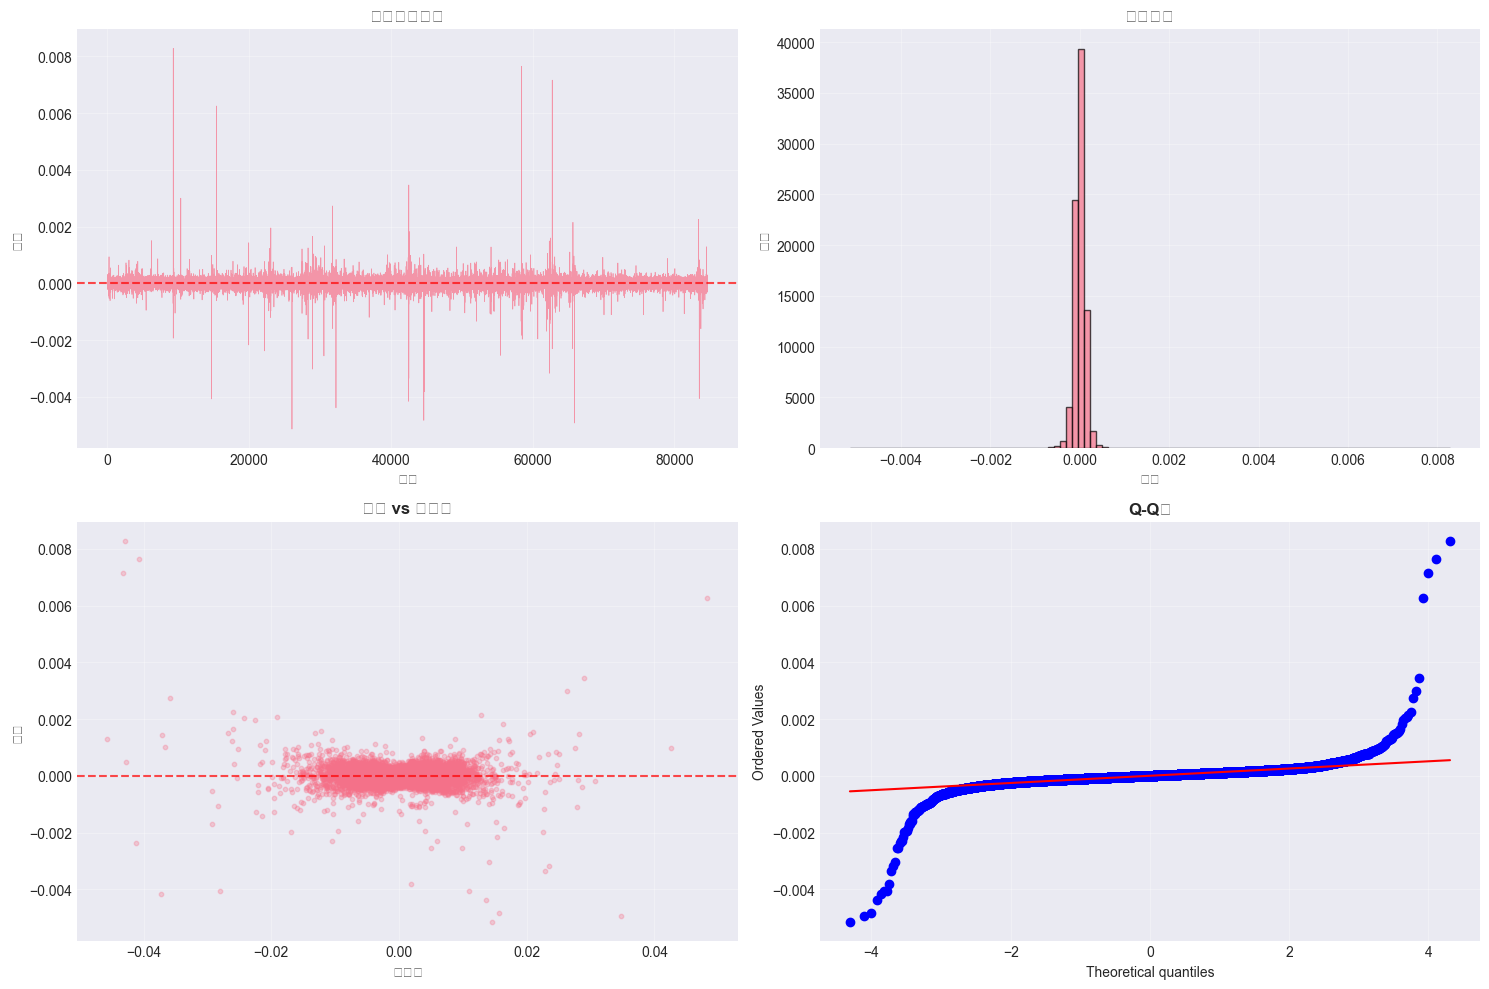


残差统计:
  均值: 0.000001
  标准差: 0.000149
  最小值: -0.005139
  最大值: 0.008282


In [28]:
# 残差分析
residuals = y_val - y_val_pred

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 残差时间序列
axes[0, 0].plot(residuals, linewidth=0.5, alpha=0.7)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
axes[0, 0].set_title('残差时间序列', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('索引')
axes[0, 0].set_ylabel('残差')
axes[0, 0].grid(True, alpha=0.3)

# 残差分布
axes[0, 1].hist(residuals, bins=100, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('残差分布', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('残差')
axes[0, 1].set_ylabel('频数')
axes[0, 1].grid(True, alpha=0.3)

# 残差 vs 预测值
axes[1, 0].scatter(y_val_pred, residuals, alpha=0.3, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
axes[1, 0].set_title('残差 vs 预测值', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('预测值')
axes[1, 0].set_ylabel('残差')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q图
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q图', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n残差统计:")
print(f"  均值: {residuals.mean():.6f}")
print(f"  标准差: {residuals.std():.6f}")
print(f"  最小值: {residuals.min():.6f}")
print(f"  最大值: {residuals.max():.6f}")

## 10. 测试集预测

**重要**: 对于测试集，我们需要使用训练集的最后几个值来创建滞后特征。

In [29]:
# 为测试集准备数据
# 需要将训练集的最后几行附加到测试集前面，以便创建滞后特征

# 获取最大滞后值
max_lag = 96  # 根据特征工程中使用的最大滞后

# 从训练集获取最后max_lag行
train_tail = train_df.tail(max_lag).copy()

# 合并训练尾部和测试集
test_with_history = pd.concat([train_tail, test_df], ignore_index=True)

print(f"训练集尾部行数: {len(train_tail)}")
print(f"测试集行数: {len(test_df)}")
print(f"合并后行数: {len(test_with_history)}")

训练集尾部行数: 96
测试集行数: 2881
合并后行数: 2977


In [30]:
# 为测试集创建特征
# 注意：测试集没有Target列，我们使用Close作为代理
print("为测试集创建特征...\n")

# 在合并的数据上创建特征
test_featured = create_all_features(test_with_history.copy(), 
                                   target_col='Close', 
                                   is_train=False)

# 只保留原始测试集的行
test_featured = test_featured.tail(len(test_df)).reset_index(drop=True)

print(f"测试集特征形状: {test_featured.shape}")

为测试集创建特征...

原始数据形状: (2977, 7)
添加时间特征后: (2977, 21)
添加价格特征后: (2977, 30)
测试集特征创建后: (2977, 65)
测试集特征形状: (2881, 65)


In [33]:
# 确保测试集有所有需要的特征
missing_features = set(feature_cols) - set(test_featured.columns)
extra_features = set(test_featured.columns) - set(feature_cols) - {'Timestamp'}

print(f"缺失特征数: {len(missing_features)}")
if missing_features:
    print("缺失特征:", list(missing_features)[:10])
    # 为缺失特征填充0
    for feat in missing_features:
        test_featured[feat] = 0

print(f"额外特征数: {len(extra_features)}")
if extra_features:
    print("额外特征:", list(extra_features)[:10])

# 只保留需要的特征列（排除额外列）
available_features = [col for col in feature_cols if col in test_featured.columns]
print(f"\n可用特征数: {len(available_features)}/{len(feature_cols)}")

# 如果有缺失特征，补充到available_features
if missing_features:
    available_features = feature_cols

# 确保特征顺序一致，只选择数值型特征
X_test_df = test_featured[available_features].copy()

# 检查并转换所有列为数值类型
print("\n检查数据类型...")
non_numeric_cols = []
for col in X_test_df.columns:
    if X_test_df[col].dtype == 'object' or X_test_df[col].dtype.name == 'category':
        non_numeric_cols.append(col)
        print(f"  转换列 '{col}' 从 {X_test_df[col].dtype} 到数值类型")
        X_test_df[col] = pd.to_numeric(X_test_df[col], errors='coerce')

if non_numeric_cols:
    print(f"已转换 {len(non_numeric_cols)} 个非数值列")
else:
    print("所有列已是数值类型")

# 转换为numpy数组
X_test = X_test_df.values.astype(float)

print(f"\n测试集特征矩阵形状: {X_test.shape}")
print(f"数据类型: {X_test.dtype}")
print(f"是否有NaN: {np.isnan(X_test).any()}")
print(f"是否有Inf: {np.isinf(X_test).any()}")

if np.isnan(X_test).any():
    nan_count = np.isnan(X_test).sum()
    print(f"NaN值总数: {nan_count}")
if np.isinf(X_test).any():
    inf_count = np.isinf(X_test).sum()
    print(f"Inf值总数: {inf_count}")

缺失特征数: 0
额外特征数: 1
额外特征: ['Target']

可用特征数: 63/63

检查数据类型...
所有列已是数值类型

测试集特征矩阵形状: (2881, 63)
数据类型: float64
是否有NaN: False
是否有Inf: False


In [34]:
# 处理测试集中的NaN和Inf
if np.isnan(X_test).any() or np.isinf(X_test).any():
    print("处理测试集中的NaN和Inf值...")
    
    # 替换Inf为NaN
    X_test = np.where(np.isinf(X_test), np.nan, X_test)
    
    # 用训练集的均值填充NaN
    train_means = np.nanmean(X_train, axis=0)
    for i in range(X_test.shape[1]):
        mask = np.isnan(X_test[:, i])
        if mask.any():
            X_test[mask, i] = train_means[i] if not np.isnan(train_means[i]) else 0
    
    print(f"处理后 - NaN: {np.isnan(X_test).any()}, Inf: {np.isinf(X_test).any()}")

In [35]:
# 在测试集上预测
print("在测试集上进行预测...")
test_predictions = model.predict(X_test, num_iteration=model.best_iteration)

print(f"\n预测完成!")
print(f"预测数量: {len(test_predictions)}")
print(f"预测值范围: [{test_predictions.min():.6f}, {test_predictions.max():.6f}]")
print(f"预测值均值: {test_predictions.mean():.6f}")
print(f"预测值标准差: {test_predictions.std():.6f}")

在测试集上进行预测...

预测完成!
预测数量: 2881
预测值范围: [-0.021786, 0.101854]
预测值均值: 0.036982
预测值标准差: 0.034840


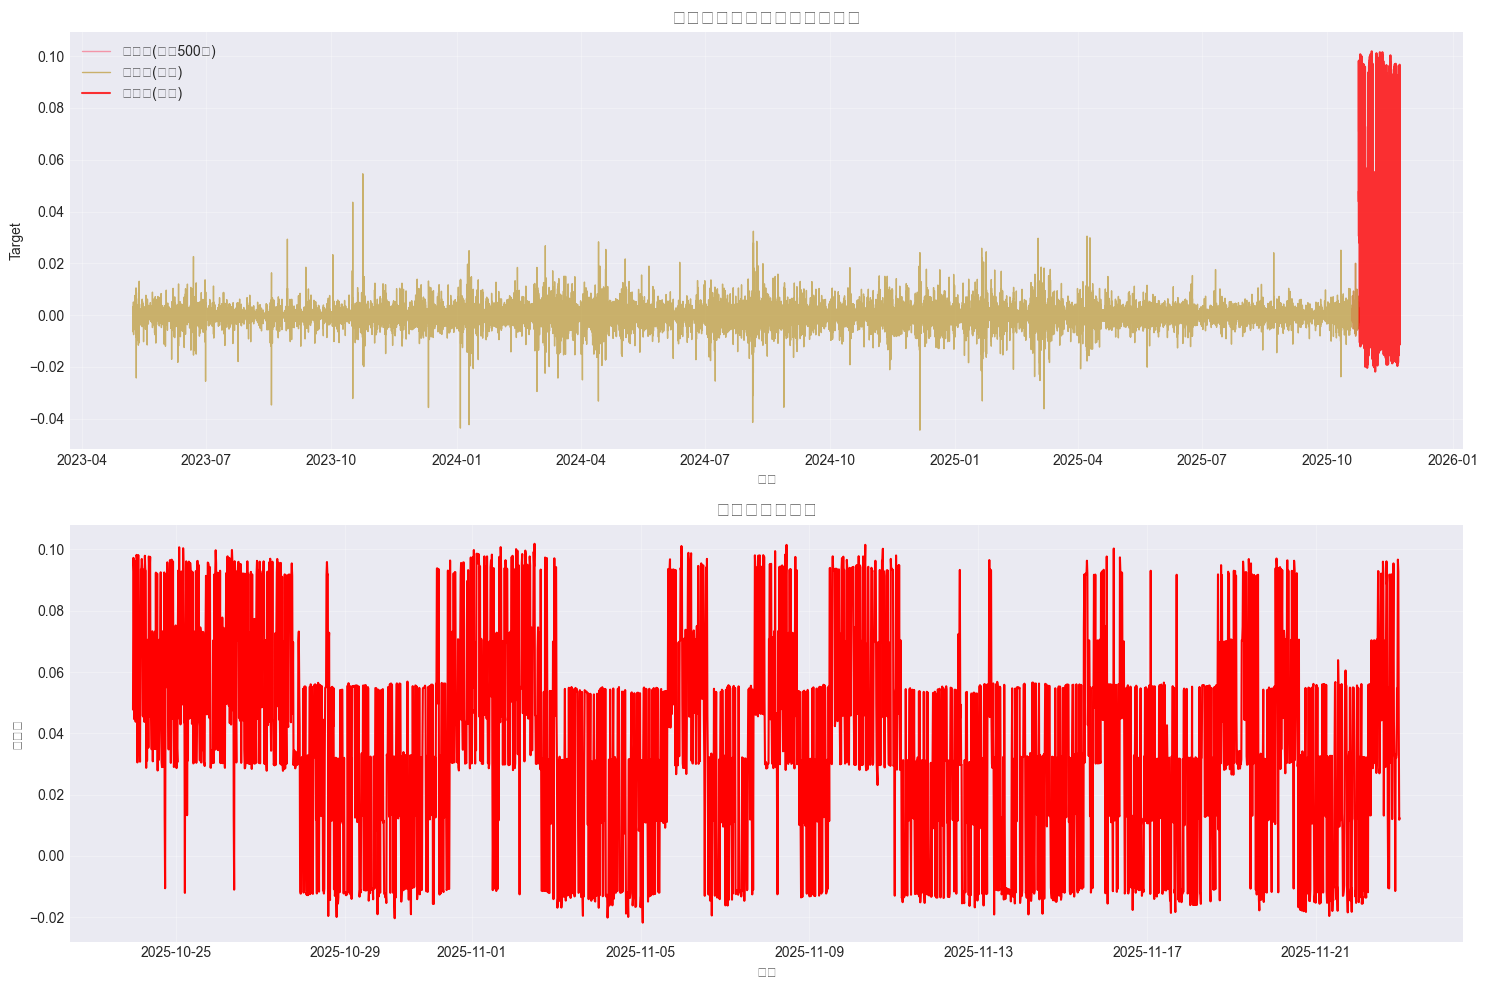

In [36]:
# 可视化测试集预测
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 训练集最后部分、验证集和测试集预测
last_train_points = 500
train_end_timestamps = timestamps.iloc[-last_train_points:]
val_timestamps_plot = timestamps.iloc[train_size:]
test_timestamps = test_df['Timestamp']

axes[0].plot(train_end_timestamps, 
             train_featured['Target'].iloc[-last_train_points:], 
             label='训练集(最后500点)', linewidth=1, alpha=0.7)
axes[0].plot(val_timestamps_plot, y_val, 
             label='验证集(实际)', linewidth=1, alpha=0.7)
axes[0].plot(test_timestamps, test_predictions, 
             label='测试集(预测)', linewidth=1.5, color='red', alpha=0.8)
axes[0].set_title('训练集、验证集和测试集预测', fontsize=14, fontweight='bold')
axes[0].set_xlabel('时间')
axes[0].set_ylabel('Target')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 只显示测试集预测
axes[1].plot(test_timestamps, test_predictions, linewidth=1.5, color='red')
axes[1].set_title('测试集预测结果', fontsize=14, fontweight='bold')
axes[1].set_xlabel('时间')
axes[1].set_ylabel('预测值')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. 生成提交文件

In [37]:
# 创建提交文件
submission_df = pd.DataFrame({
    'Timestamp': test_df['Timestamp'],
    'Prediction': test_predictions
})

# 保存提交文件
submission_dir = Path('../submissions')
submission_dir.mkdir(exist_ok=True)

submission_file = submission_dir / 'lgbm_strict_submission.csv'
submission_df.to_csv(submission_file, index=False)

print(f"✅ 提交文件已保存: {submission_file}")
print(f"\n提交文件形状: {submission_df.shape}")
print("\n提交文件预览:")
print(submission_df.head(10))
print("\n...")
print(submission_df.tail(10))

✅ 提交文件已保存: ../submissions/lgbm_strict_submission.csv

提交文件形状: (2881, 2)

提交文件预览:
            Timestamp  Prediction
0 2025-10-23 23:30:00    0.047746
1 2025-10-23 23:45:00    0.097260
2 2025-10-24 00:00:00    0.092769
3 2025-10-24 00:15:00    0.044615
4 2025-10-24 00:30:00    0.092799
5 2025-10-24 00:45:00    0.096236
6 2025-10-24 01:00:00    0.043773
7 2025-10-24 01:15:00    0.050007
8 2025-10-24 01:30:00    0.098228
9 2025-10-24 01:45:00    0.096993

...
               Timestamp  Prediction
2871 2025-11-22 21:15:00    0.033208
2872 2025-11-22 21:30:00    0.031920
2873 2025-11-22 21:45:00    0.032958
2874 2025-11-22 22:00:00    0.054834
2875 2025-11-22 22:15:00    0.055029
2876 2025-11-22 22:30:00    0.096685
2877 2025-11-22 22:45:00    0.092811
2878 2025-11-22 23:00:00    0.042999
2879 2025-11-22 23:15:00    0.011807
2880 2025-11-22 23:30:00    0.012301


In [38]:
# 提交文件统计
print("\n提交文件统计:")
print(submission_df['Prediction'].describe())

# 与验证集比较
print("\n与验证集预测比较:")
print(f"验证集预测均值: {y_val_pred.mean():.6f}")
print(f"测试集预测均值: {test_predictions.mean():.6f}")
print(f"验证集预测标准差: {y_val_pred.std():.6f}")
print(f"测试集预测标准差: {test_predictions.std():.6f}")


提交文件统计:
count    2881.000000
mean        0.036982
std         0.034846
min        -0.021786
25%         0.011338
50%         0.032632
75%         0.055627
max         0.101854
Name: Prediction, dtype: float64

与验证集预测比较:
验证集预测均值: 0.000015
测试集预测均值: 0.036982
验证集预测标准差: 0.002485
测试集预测标准差: 0.034840


## 12. 保存模型

In [39]:
# 保存模型
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

model_file = model_dir / 'lgbm_strict_model.txt'
model.save_model(str(model_file))

print(f"✅ 模型已保存: {model_file}")

# 保存特征列表
feature_file = model_dir / 'lgbm_strict_features.txt'
with open(feature_file, 'w') as f:
    for feat in feature_cols:
        f.write(f"{feat}\n")

print(f"✅ 特征列表已保存: {feature_file}")

✅ 模型已保存: ../models/lgbm_strict_model.txt
✅ 特征列表已保存: ../models/lgbm_strict_features.txt


## 总结

### 方法特点:

1. **严格的时序验证**
   - 使用时间序列分割，避免未来信息泄露
   - 验证集总是在训练集之后

2. **丰富的特征工程**
   - 滞后特征：捕捉历史模式
   - 滚动窗口特征：平滑和趋势信息
   - 时间特征：周期性模式
   - 价格特征：技术指标

3. **LightGBM优势**
   - 高效处理大规模数据
   - 自动处理缺失值
   - 特征重要性分析

4. **测试集处理**
   - 使用训练集历史数据创建滞后特征
   - 确保特征一致性

### 模型性能:
- 验证集RMSE: 见上方评估结果
- 使用了{len(feature_cols)}个特征
- 最佳迭代次数: {model.best_iteration}

### 下一步改进:
- 超参数调优（网格搜索或贝叶斯优化）
- 尝试不同的滞后窗口
- 添加更多技术指标
- 模型集成
- 特征选择